In [1]:
import pandas as pd
import numpy as np
from scipy import io
from scipy import sparse
import sys
import logging
import seaborn 
import matplotlib.pyplot as plt
from IPython.display import display, Math, Latex
from time import time

from sklearn import metrics
from sklearn.metrics.pairwise import linear_kernel,pairwise_distances
from sklearn.feature_extraction import text as txt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer, HashingVectorizer
from sklearn import decomposition
from operator import itemgetter
from sklearn.naive_bayes import MultinomialNB


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans, MiniBatchKMeans, AffinityPropagation

from optparse import OptionParser

import bs4 as bs4
import re, sys

from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.regexp import WordPunctTokenizer
import nltk

import gensim
from gensim import corpora, similarities, models
from gensim import matutils

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/bwu/anaconda/lib/python2.7/site-packages/numpy/lib/utils.py:95: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  warnings.warn(depdoc, DeprecationWarning)
/Users/bwu/anaconda/lib/python2.7/site-packages/scipy/lib/_util.py:35: DeprecationWarning: Module scipy.linalg.blas.fblas is deprecated, use scipy.linalg.blas instead
  DeprecationWarning)
/Users/bwu/anaconda/lib/python2.7/site-packages/scipy/lib/_util.py:35: DeprecationWarning: Module scipy.linalg.blas.fblas is deprecated, use scipy.linalg.blas instead
  DeprecationWarning)
/Users/bwu/anaconda/lib/python2.7/site-packages/scipy/lib/_util.py:35: DeprecationWarning: Module scipy.linalg.blas.fblas is deprecated, use scipy.linalg.blas instead
  DeprecationWarning)
/Users/bwu/anaconda/lib/python2.7/site-packages/scipy/lib/_util.py:35: DeprecationWarning: Module scipy.linalg.blas.fblas is deprecated, use scipy.linalg.blas instead
  

In [64]:
description = pd.read_csv("/Users/bwu/testing/prop_descriptions_los_angeles.csv", 
                          header = None, 
                          names = ["description"],
                          delimiter = "\n", encoding = "ISO-8859-1")

In [65]:
description.head()

,description
0,_source_prop_common_description
1,"5 Units in county area NO RENT CONTROL, a fron..."
2,"This stylish, contemporary, multi-level home i..."
3,Welcome to this wonderfully appointed 3-bedroo...
4,A rare opportunity to own a piece of Hollywood...


In [66]:
#Text Cleaning Functions
def mrclean(text):
    '''
    NAME
            mrclean
    SYNOPSIS
            Cleans incoming text
    DESCRIPTION
            Removes all untranslatable unicode
    '''
    c = ['\xe2','\x80','\x93','\xc2','\xa0','\n', '\r', '\u2019', '\n\n', '\x96']  
    return re.sub('[%s]' % ''.join(c), '', text)

def soupText(eText):
    '''
    NAME
            soupText

    SYNOPSIS
            Removes all the HTML tags using BeautifulSoup

    DESCRIPTION
            Explicitly calls utf-8, replaces all double quotes with single and calls on helper function mrclean
    '''
    eText = str(eText.encode("utf-8").replace("'",'"') )
    soup = bs4.BeautifulSoup(eText)
    cleanText = soup.findAll(text=True)  #.get_text()
    return mrclean(''.join(cleanText))

In [67]:
#Stopwords specific to property descriptions 
additional_stop_words = []

In [68]:
grouped_descriptions = []
for y in description["description"]:
    w = ''.join([i if ord(i) < 128 else '' for i in y])
    unicode(w)
    soupText(w)
    grouped_descriptions.append(w)

In [69]:
len(grouped_descriptions)

11314

In [70]:
n_samples = len(grouped_descriptions)
n_features = 10000

tfidf = TfidfVectorizer(min_df = 10, 
                         #max_df =.99,
                         max_features = n_features, 
                         stop_words = txt.ENGLISH_STOP_WORDS.union(additional_stop_words),
                         sublinear_tf=True,
                         ngram_range=(1,4),
                         )

counts = tfidf.fit_transform(grouped_descriptions)
X = TfidfTransformer().fit_transform(counts)

print X.shape
print len(grouped_descriptions)
print type(X)
X_transformed = X.T
print X_transformed.shape


(11314, 10000)
11314
<class 'scipy.sparse.csr.csr_matrix'>
(10000, 11314)


In [71]:
#NMF for grouped comments
n_topics = 50
n_top_words = 15

print("size of corpus: {}".format(len(grouped_descriptions)))

t0 = time()

# Fit the NMF model
print("Fitting the NMF model on with n_samples=%d and n_features=%d..."
      % (n_samples, X.shape[1]))
nmf = decomposition.NMF(n_components=n_topics).fit(X)
print("done in %0.3fs." % (time() - t0))

# Inverse the vectorizer vocabulary to be able
feature_names = tfidf.get_feature_names()

for topic_idx, topic in enumerate(nmf.components_):
    print("Topic #%d:" % topic_idx)
    print(" ".join( [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]] ))
    print

size of corpus: 11314
Fitting the NMF model on with n_samples=11314 and n_features=10000...
done in 370.654s.
Topic #0:
outdoor suite master suite pool master spa indoor outdoor custom level doors glass views indoor gourmet stunning

Topic #1:
great investment investment investment opportunity great investment opportunity investment property great investment property rent live unit rent unit rent live unit great opportunity live rental area property live

Topic #2:
short sale subject lender lender approval subject lender subject lender approval sale subject sale subject lender short sale subject lender sale subject lender approval approval short sale subject short sale sale approval

Topic #3:
fixer major fixer fixer upper bring contractor contractor upper lots potential bring major perfect investors make dream builders imagination lots investors

Topic #4:
closet walk closet walk master storage master bedroom tub shower condo balcony hoa stainless bedroom walk stainless steel master b

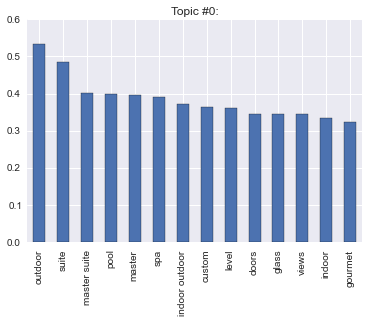

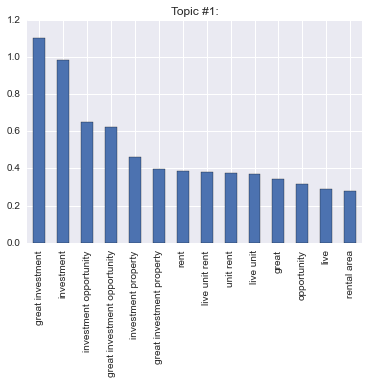

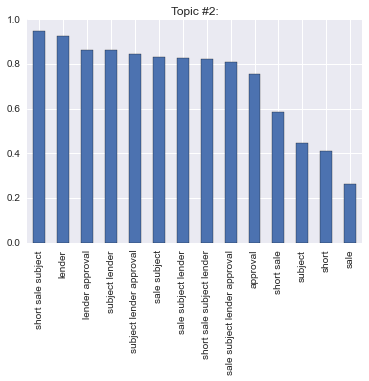

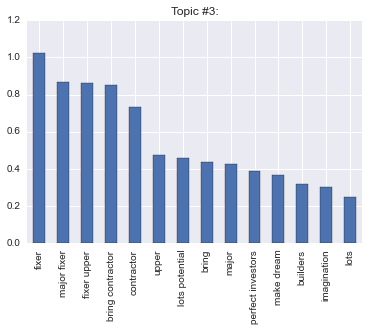

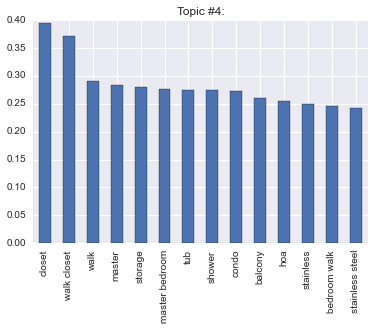

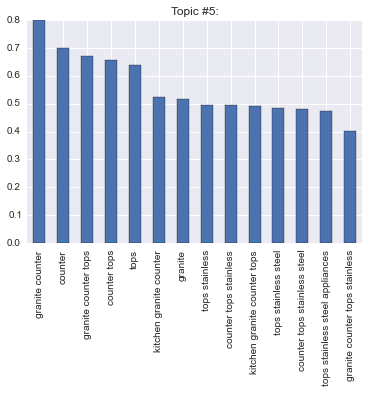

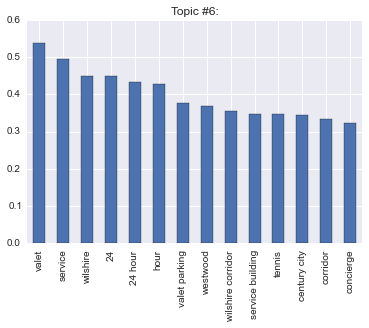

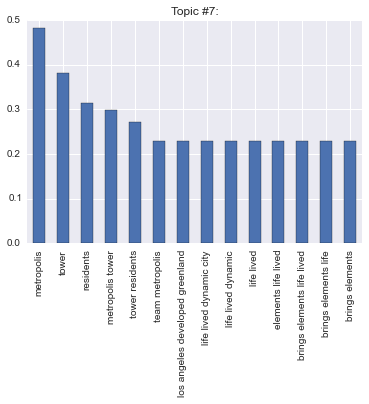

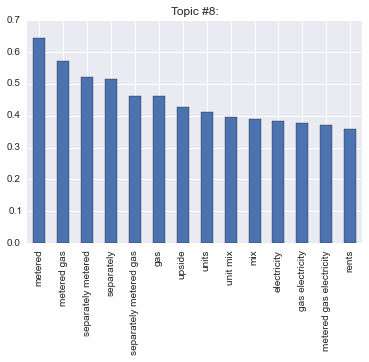

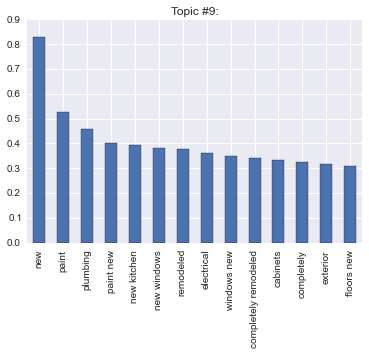

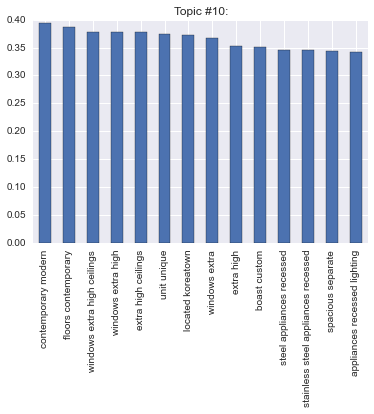

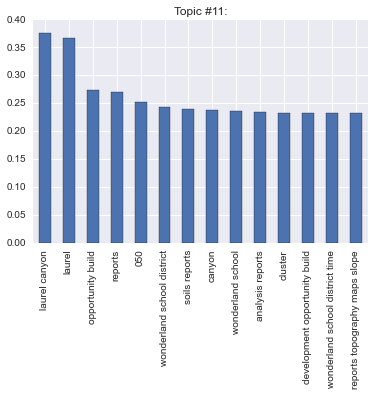

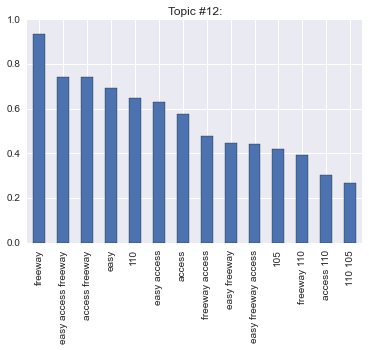

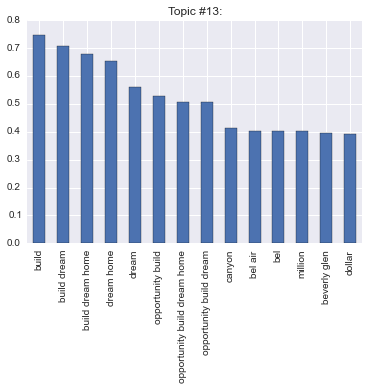

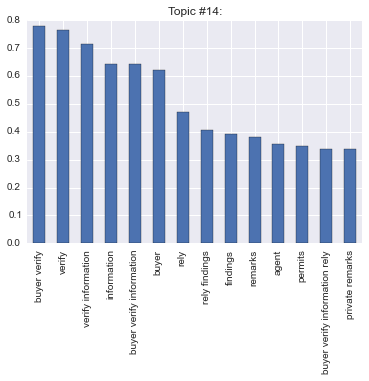

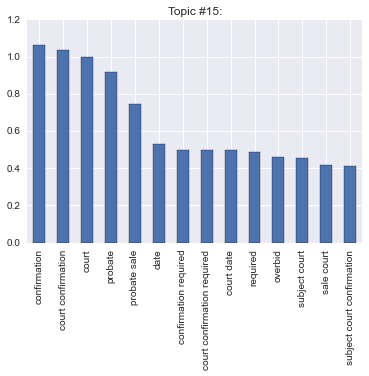

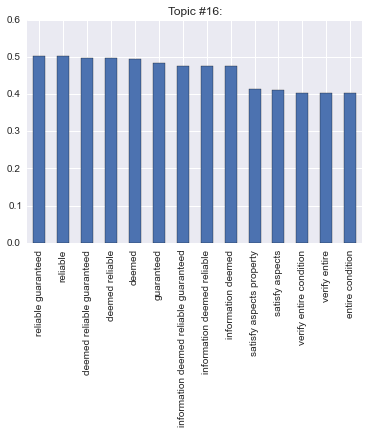

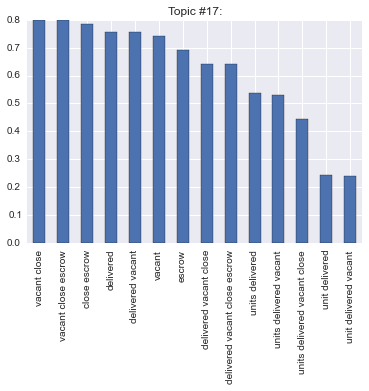

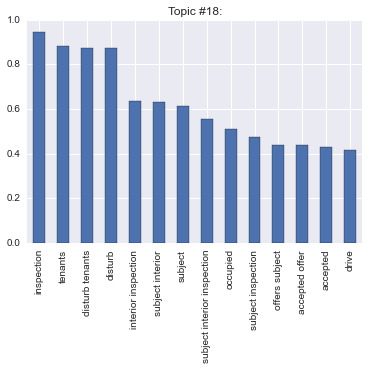

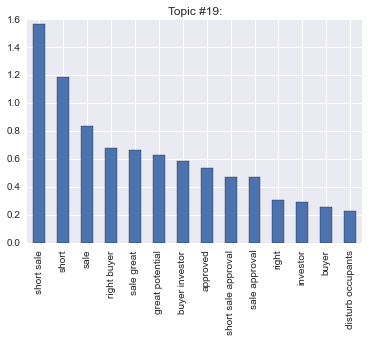

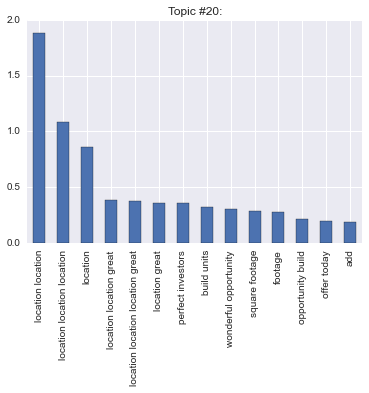

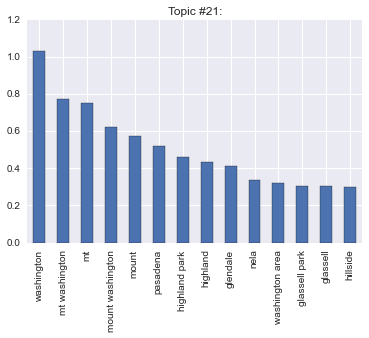

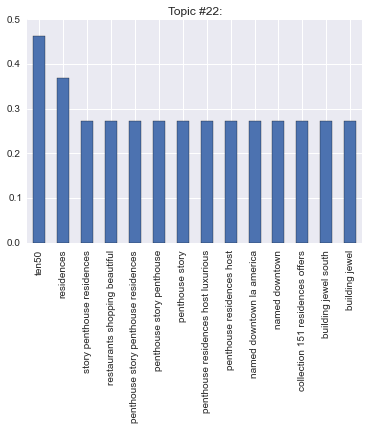

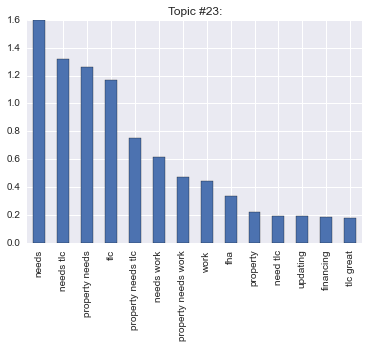

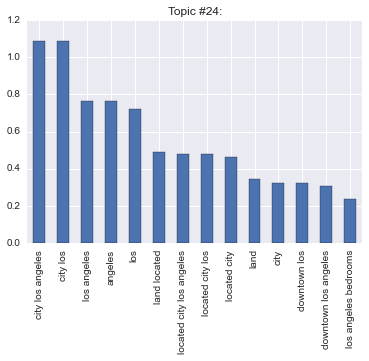

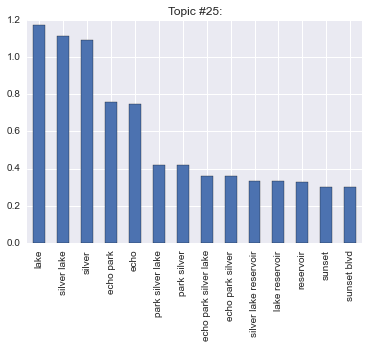

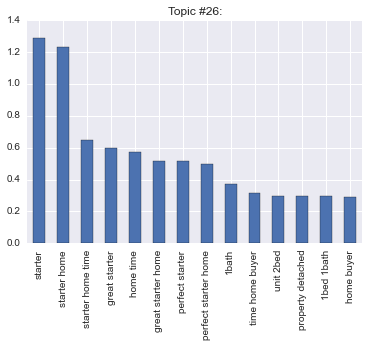

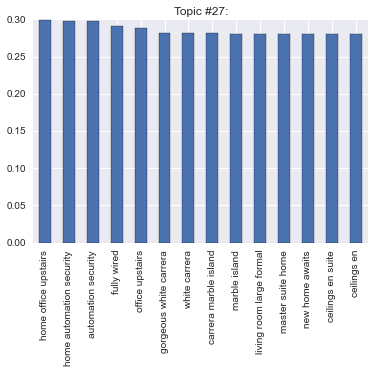

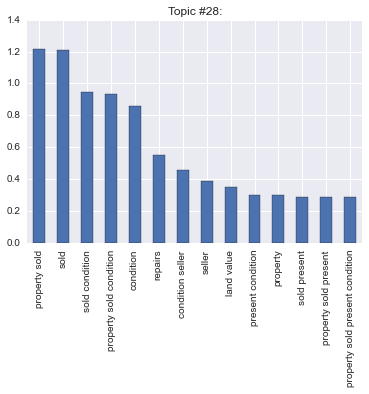

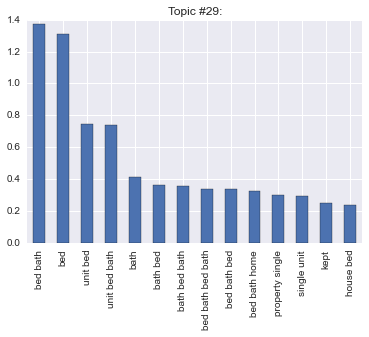

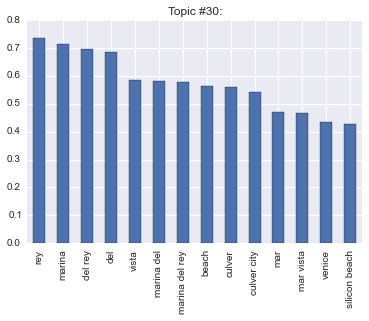

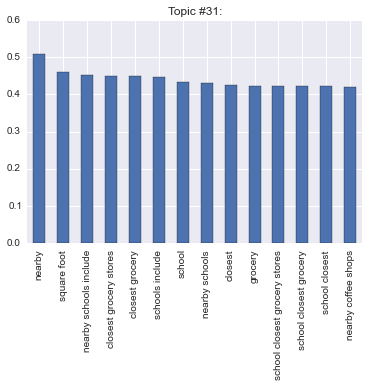

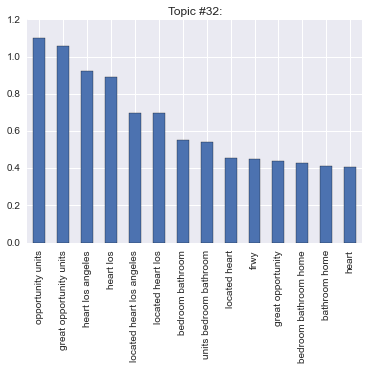

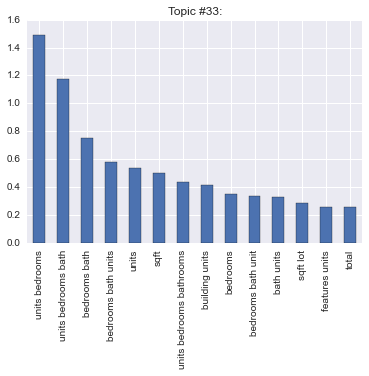

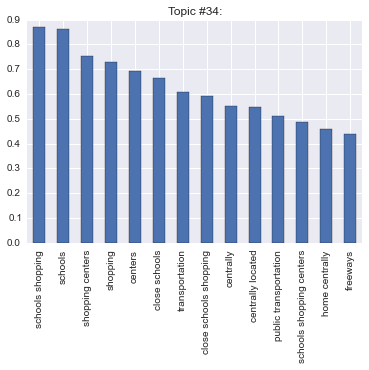

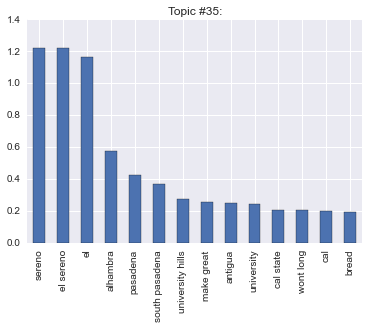

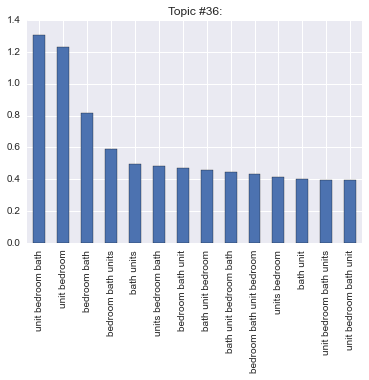

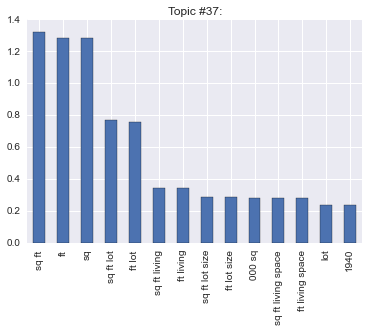

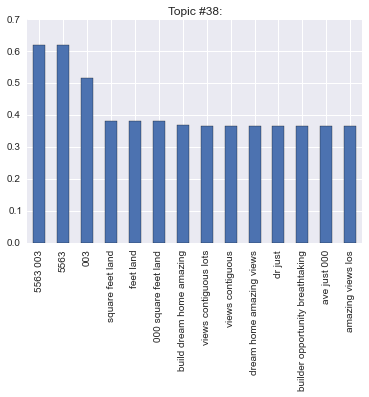

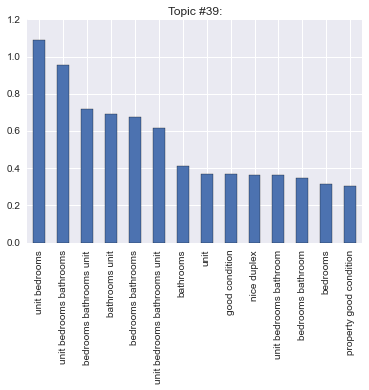

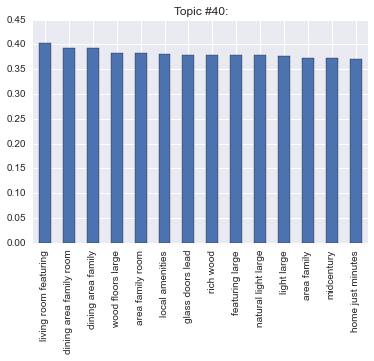

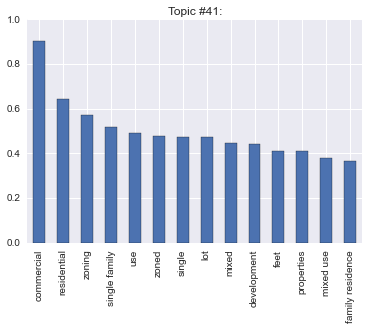

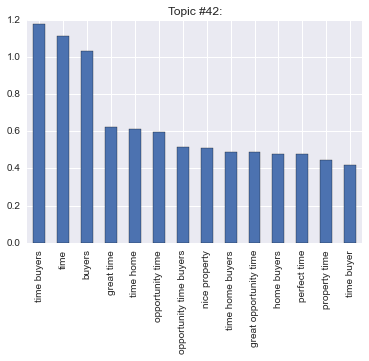

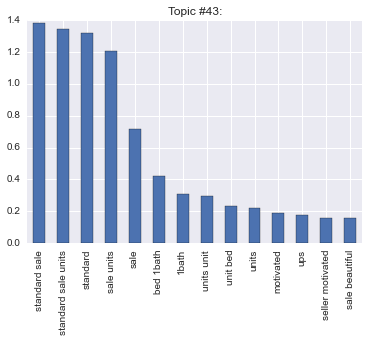

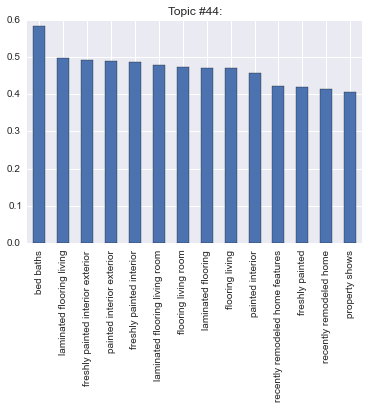

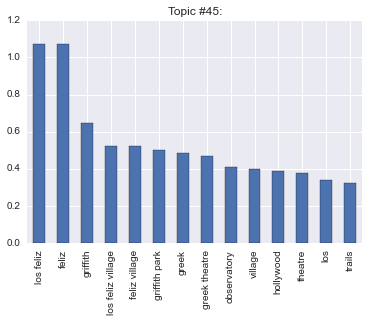

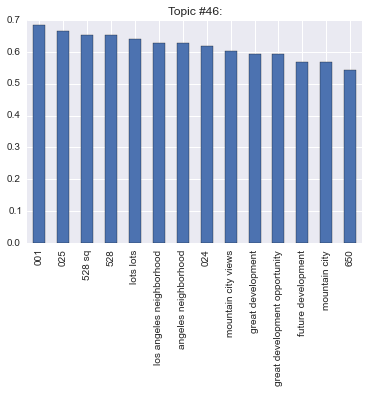

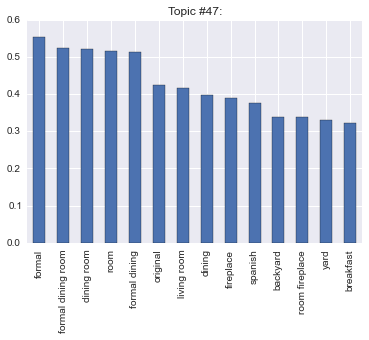

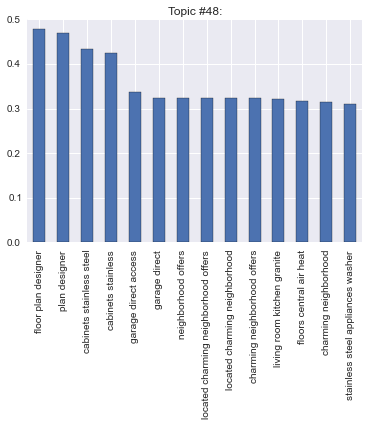

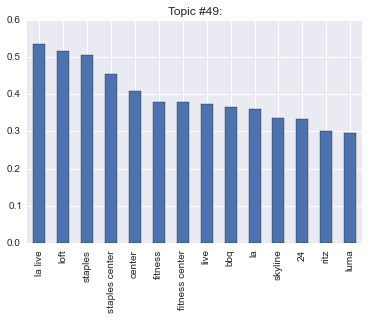

In [72]:
for topic_idx, topic in enumerate(nmf.components_):

    words = [feature_names[i] for i in topic.argsort()[:-(n_top_words):-1]]
    scores = [topic[i] for i in topic.argsort()[:-(n_top_words):-1]]

    dicta = {word: score for score, word in zip(scores, words)}
    
    s = pd.Series(dicta)
    t = s.order(ascending=False)

    plt.figure()
    plt.title("Topic #%d:" % topic_idx)
    t.plot(kind='bar');

In [73]:
#Word clouds
import vincent
vincent.core.initialize_notebook()

topics_dicts = []
H = nmf.components_
n_topics = nmf.n_components_
feature_names = tfidf.get_feature_names()

for i in xrange(n_topics):
    # n_top_words of keys and values
    keys, values = zip(*sorted(zip(feature_names, H[i]), key = lambda x: x[1])[:-n_top_words:-1])
    val_arr = np.array(values)
    norms = val_arr / np.sum(val_arr)
    #normalize = lambda x: int(x / (max(counter.values()) - min(counter.values())) * 90 + 10)
    topics_dicts.append(dict(zip(keys, np.rint(norms* 300))))

for i in xrange(n_topics):
    word_cloud = vincent.Word(topics_dicts[i])
    word_cloud.width = 300
    word_cloud.height = 300
    word_cloud.padding = 0
    word_cloud.data[0].transform[0].rotate['random'] = [0,0]
    word_cloud.display();
#     word_cloud.to_json('static/bar%d.json' % i, html_out=True, html_path='bar_template.html')
